In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from google_play_scraper import reviews, Sort
from collections import Counter
from io import StringIO
import requests
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from wordcloud import WordCloud
import warnings
import csv
import string
import re
import string
import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('wordnet')

warnings.filterwarnings('ignore')

# Unduh stopwords dan resource NLTK
nltk.download('stopwords')

# Inisialisasi stopwords bahasa Indonesia
stop_words = set(stopwords.words('indonesian'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### DATA SCRAPING

In [28]:
# Scraping data review Telegram dari Google Play Store
scrapreview, continuation_token = reviews(
    'com.supercell.clashofclans',  # ID Telegram
    lang='en',
    country='us',
    sort=Sort.NEWEST,
    count=15000, 
)

# Lanjutkan scraping data jika ada continuation token
result, _ = reviews(
    'com.supercell.clashofclans',
    continuation_token=continuation_token
)

# Buat DataFrame dari data review
review_data = pd.DataFrame(scrapreview)

In [29]:
review_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   reviewId              15000 non-null  object        
 1   userName              15000 non-null  object        
 2   userImage             15000 non-null  object        
 3   content               15000 non-null  object        
 4   score                 15000 non-null  int64         
 5   thumbsUpCount         15000 non-null  int64         
 6   reviewCreatedVersion  11722 non-null  object        
 7   at                    15000 non-null  datetime64[ns]
 8   replyContent          0 non-null      object        
 9   repliedAt             0 non-null      object        
 10  appVersion            11722 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(8)
memory usage: 1.3+ MB


### DATA CLEANING

In [30]:
# Mengatur penggunaan stemmer bahasa Indonesia dari Sastrawi
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Function untuk membersihkan teks review dengan penghapusan stopwords dan stemming
def preprocessing_text(text):
    def cleaning_text(text):
        text = re.sub(r'@\w+', '', text)  # Hapus mention
        text = re.sub(r'#\w+', '', text)  # Hapus hashtag
        text = re.sub(r'RT[\s]', '', text)  # Menghapus RT
        text = re.sub(r'https?://\S+|www.\S+', '', text)  # Hapus URL
        text = re.sub(r'<.*?>', '', text)  # Hapus tag HTML
        text = re.sub(r'\d+', '', text)  # Hapus angka
        text = text.lower()  # Ubah teks menjadi lowercase
        text = re.sub(r'[^\w\s]', '', text)  # Menghapus karakter selain huruf dan angka
        text = text.replace('\n', ' ')  # Mengganti baris baru dengan spasi
        text = text.translate(str.maketrans('', '', string.punctuation))
        text = text.strip()
        return text
    
    def casefolding_text(text):
        return text.lower()
    
    def tokenizing_text(text):
        return word_tokenize(text)
    
    def filtering_text(tokens):
        list_stopwords = set(stopwords.words('english'))
        return [word for word in tokens if word.lower() not in list_stopwords]
    
    '''def stemming_text(tokens):
        factory = StemmerFactory()
        stemmer = factory.create_stemmer()
        return ' '.join([stemmer.stem(word) for word in tokens])'''
    
    def stem_text(tokens):
        stemmer = PorterStemmer()
        stemmed_text = ' '.join([stemmer.stem(word) for word in tokens])
        return stemmed_text

    
    text = cleaning_text(text)
    text = casefolding_text(text)
    tokens = tokenizing_text(text)
    tokens = filtering_text(tokens)
    text = stem_text(tokens)

    return text

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [31]:
review_data

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,1d70dbe4-e0cb-4a86-bbcd-2351678f60b8,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,It's cool. pretty addicted to it try it! There...,5,0,None,2024-07-08 04:47:35,None,None,None
1,1968fd3a-c7f9-4e64-9b6d-37f49eafb000,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,fayjzugz GC hi hd for dust be so hd si,5,1,None,2024-07-06 22:09:12,None,None,None
2,6332a286-0e33-42f7-86cc-ed2021ba6b8c,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,Nice game,5,1,16.386.14,2024-07-06 21:55:14,None,None,16.386.14
3,89bd20bd-fbc7-4e97-82e6-cd5dc2680e43,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,Unlimited hero event continue. Bd hole do this...,5,0,16.386.14,2024-07-06 21:21:40,None,None,16.386.14
4,b15a086f-a4d7-4bfb-9ae8-2aab5148b375,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,So nice game,5,0,16.386.14,2024-07-06 19:40:17,None,None,16.386.14
...,...,...,...,...,...,...,...,...,...,...,...
14995,1366f50c-9450-4b53-ad85-324578b79bf9,Kalpana Sikarwar,https://play-lh.googleusercontent.com/a/ACg8oc...,It gets hard when plays about 1 to 2 days,2,0,None,2024-05-09 12:57:15,None,None,None
14996,79c72c9c-6b05-4e5a-af79-272bc8d06f7f,M.Geetha M.sanjay,https://play-lh.googleusercontent.com/a-/ALV-U...,Good,3,0,16.253.25,2024-05-09 12:51:59,None,None,16.253.25
14997,9696f3be-0eae-448c-b978-058c699b4cfb,औखतोख लोगक,https://play-lh.googleusercontent.com/a/ACg8oc...,Good,5,0,16.253.25,2024-05-09 12:45:15,None,None,16.253.25
14998,7f62359e-32f0-4eba-a133-ae5f4bf20147,Allan Rama,https://play-lh.googleusercontent.com/a-/ALV-U...,Nice game,4,0,16.253.25,2024-05-09 12:44:14,None,None,16.253.25


In [32]:
# Terapkan preprocessing pada kolom content untuk mendapatkan content_clean
review_data['content_clean'] = review_data['content'].apply(preprocessing_text)

In [33]:
# Mengambil feature content dan content_clean saja
review_data = review_data[['content', 'content_clean']]
review_data

,content,content_clean
0,It's cool. pretty addicted to it try it! There...,cool pretti addict tri there mani thing
1,fayjzugz GC hi hd for dust be so hd si,fayjzugz gc hi hd dust hd si
2,Nice game,nice game
3,Unlimited hero event continue. Bd hole do this...,unlimit hero event continu bd hole hero max
4,So nice game,nice game
...,...,...
14995,It gets hard when plays about 1 to 2 days,get hard play day
14996,Good,good
14997,Good,good
14998,Nice game,nice game


In [34]:
# Merubah baris yang hanya berisi spasi atau nilai NaN
review_data.replace(r'^\s*$', np.nan, regex=True, inplace=True)

In [35]:
# Menampilkan data yang bernilai NaN
nan_values = review_data[review_data.isna().any(axis=1)]
print(nan_values)

        content content_clean
29            👍           NaN
97           🗿🗿           NaN
119           😊           NaN
121         😄😄😄           NaN
126    🇮🇳🇺🇸🇨🇳🇲🇽           NaN
...         ...           ...
14754         💩           NaN
14780         💪           NaN
14855    👍👍👍👍👍👍           NaN
14942       👍✔️           NaN
14962      :-)😡           NaN

[433 rows x 2 columns]


In [36]:
# Menghapus data yang bernilai NaN
review_data.dropna(inplace=True)

In [37]:
# Menghapus data yang duplikat
review_data.drop_duplicates()

,content,content_clean
0,It's cool. pretty addicted to it try it! There...,cool pretti addict tri there mani thing
1,fayjzugz GC hi hd for dust be so hd si,fayjzugz gc hi hd dust hd si
2,Nice game,nice game
3,Unlimited hero event continue. Bd hole do this...,unlimit hero event continu bd hole hero max
4,So nice game,nice game
...,...,...
14991,Payment issue,payment issu
14993,Amazing game.,amaz game
14994,This game doesn't give you second chance if yo...,game doesnt give second chanc got network disc...
14995,It gets hard when plays about 1 to 2 days,get hard play day


### DATA LABELING

In [38]:
# MEngambil label positif dan negatif dari lexicon
lexicon_positive = {}
response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')
if response.status_code == 200:
    reader = csv.reader(StringIO(response.text), delimiter=',')
    for row in reader:
        lexicon_positive[row[0]] = int(row[1])
else:
    print("Gagal mengambil data lexicon positif")

lexicon_negative = {}
response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')
if response.status_code == 200:
    reader = csv.reader(StringIO(response.text), delimiter=',')
    for row in reader:
        lexicon_negative[row[0]] = int(row[1])
else:
    print("Gagal mengambil data lexicon negatif")

In [39]:
# Function untuk memberikan label sentiment menggunakan lexicon
def sentiment_analysis_lexicon_indonesia(text):
    score = 0
    for word in text.split():
        if word in lexicon_positive:
            score += lexicon_positive[word]
        elif word in lexicon_negative:
            score += lexicon_negative[word]
    if score > 0:
        label = 'Positive'
    elif score == 0:
        label = 'Neutral'
    else:
        label = 'Negative'
    return score, label

In [40]:
# Terapkan labeling pada data review
results = review_data['content_clean'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
review_data['score'] = results[0]
review_data['label'] = results[1]
review_data['label'].value_counts()

label
Positive    10190
Neutral      3371
Negative     1006
Name: count, dtype: int64

In [41]:
review_data

,content,content_clean,score,label
0,It's cool. pretty addicted to it try it! There...,cool pretti addict tri there mani thing,-1,Negative
1,fayjzugz GC hi hd for dust be so hd si,fayjzugz gc hi hd dust hd si,1,Positive
2,Nice game,nice game,6,Positive
3,Unlimited hero event continue. Bd hole do this...,unlimit hero event continu bd hole hero max,0,Neutral
4,So nice game,nice game,6,Positive
...,...,...,...,...
14995,It gets hard when plays about 1 to 2 days,get hard play day,0,Neutral
14996,Good,good,5,Positive
14997,Good,good,5,Positive
14998,Nice game,nice game,6,Positive


In [42]:
review_data.to_csv('review_data_clean.csv', index=False)

### EDA (Exploratory Data Analysis)

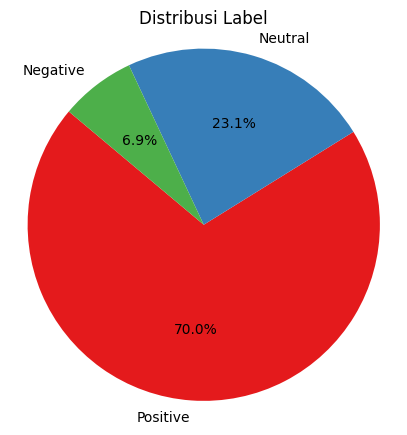

label
Positive    10190
Neutral      3371
Negative     1006
Name: count, dtype: int64


In [43]:
# Tampilkan distribusi label
label_counts = review_data['label'].value_counts()
plt.figure(figsize=(5, 5), facecolor='white')
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('Set1'))
plt.title('Distribusi Label')
plt.axis('equal')
plt.show()

print(label_counts)

Berdasarkan data distribusi label diatas dapat disimpulkan bahwa :
- Nilai Positif sebanyak 9570 data dengan persentase 48.9%
- Nilai Negatif sebanyak 6805 data dengan persentase 34.8%
- Nilai Netral sebanyak 3197 data dengan persentase 16.3%

Statistik Distribusi Panjang Teks Original:
count    14567.000000
mean         9.726162
std         14.907635
min          1.000000
25%          2.000000
50%          4.000000
75%         10.000000
max        120.000000
Name: content_length, dtype: float64

Statistik Distribusi Panjang Teks Setelah Pembersihan:
count    14567.000000
mean         5.541841
std          7.848395
min          1.000000
25%          2.000000
50%          2.000000
75%          6.000000
max         99.000000
Name: content_clean_length, dtype: float64


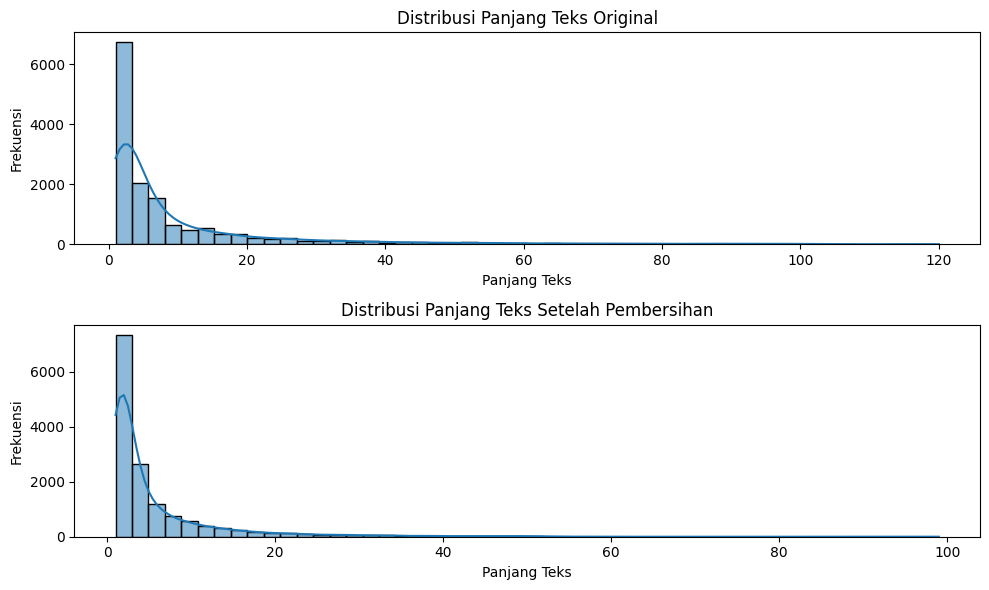

In [44]:
# Tampilkan distribusi panjang teks sebelum dan setelah preprocessing
review_data['content_length'] = review_data['content'].apply(lambda x: len(str(x).split()))
review_data['content_clean_length'] = review_data['content_clean'].apply(lambda x: len(str(x).split()))

# Menghitung distribusi panjang teks
original_text_stats = review_data['content_length'].describe()
cleaned_text_stats = review_data['content_clean_length'].describe()

# Menampilkan statistik distribusi panjang teks dalam teks
print("Statistik Distribusi Panjang Teks Original:")
print(original_text_stats)
print("\nStatistik Distribusi Panjang Teks Setelah Pembersihan:")
print(cleaned_text_stats)

plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
sns.histplot(review_data['content_length'], kde=True, bins=50)
plt.title('Distribusi Panjang Teks Original')
plt.xlabel('Panjang Teks')
plt.ylabel('Frekuensi')

plt.subplot(2, 1, 2)
sns.histplot(review_data['content_clean_length'], kde=True, bins=50)
plt.title('Distribusi Panjang Teks Setelah Pembersihan')
plt.xlabel('Panjang Teks')
plt.ylabel('Frekuensi')
plt.tight_layout()
plt.show()



Statistik yang diberikan menggambarkan perubahan distribusi panjang teks pada review setelah proses cleaning. Berikut adalah kesimpulan dari perbandingan statistik antara panjang teks sebelum dan setelah cleaning:

- Jumlah Data (count): Tidak ada perubahan dalam jumlah data, tetap 19579.
- Rata-rata (mean): Panjang teks rata-rata sebelum cleaning adalah 10.66, turun menjadi 6.79 setelah cleaning. Ini menunjukkan bahwa proses cleaning cenderung mengurangi rata-rata panjang teks.
- Standar Deviasi (std): Standar deviasi turun dari 12.32 menjadi 7.89 setelah cleaning. Ini menunjukkan bahwa variasi panjang teks di antara data telah berkurang setelah cleaning.
- Nilai Minimum (min): Tidak ada perubahan, tetap 1.
- Kuartil Pertama (25%): Tidak ada perubahan, tetap 2.
- Kuartil Kedua/Median (50%): Panjang teks median turun dari 6 menjadi 4 setelah cleaning.
- Kuartil Ketiga (75%): Panjang teks kuartil ketiga turun dari 14 menjadi 9 setelah cleaning.
- Nilai Maksimum (max): Panjang teks maksimum sedikit meningkat dari 129 menjadi 133 setelah cleaning.

Dari visualisasi yang dihasilkan, terlihat bahwa frekuensi kata meningkat setelah dilakukan proses cleaning. Sebelumnya, frekuensi kata berkisar sekitar 6000, namun setelah proses pembersihan, frekuensinya naik menjadi lebih dari 8000. Hal ini menunjukkan bahwa proses clearning teks berhasil meningkatkan frekuensi kata pada dataset.

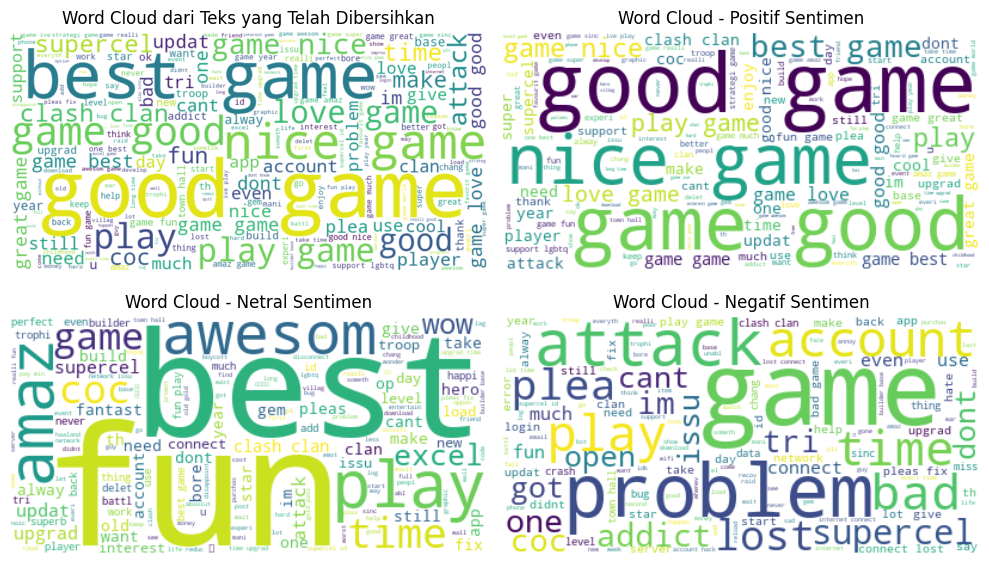

In [46]:
# Menggabungkan semua teks
all_text = ' '.join(review_data['content_clean'])

# Menggabungkan teks berlabel positif, netral, dan negatif
positive_texts = ' '.join(review_data[review_data['label'] == 'Positive']['content_clean'])
neutral_texts = ' '.join(review_data[review_data['label'] == 'Neutral']['content_clean'])
negative_texts = ' '.join(review_data[review_data['label'] == 'Negative']['content_clean'])

# Membuat word cloud untuk semua teks
wordcloud_all = WordCloud(width=800, height=400, background_color='white').generate(all_text)
wordcloud_positive = WordCloud(width=400, height=200, background_color='white').generate(positive_texts)
wordcloud_neutral = WordCloud(width=400, height=200, background_color='white').generate(neutral_texts)
wordcloud_negative = WordCloud(width=400, height=200, background_color='white').generate(negative_texts)

# Menampilkan word cloud dalam subplot
plt.figure(figsize=(10, 6))

plt.subplot(2, 2, 1)
plt.imshow(wordcloud_all, interpolation='bilinear')
plt.title('Word Cloud dari Teks yang Telah Dibersihkan')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Word Cloud - Positif Sentimen')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(wordcloud_neutral, interpolation='bilinear')
plt.title('Word Cloud - Netral Sentimen')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Word Cloud - Negatif Sentimen')
plt.axis('off')

plt.tight_layout()
plt.show()

[('game', 8781), ('good', 3324), ('play', 1774), ('nice', 1646), ('best', 1328), ('time', 1092), ('love', 949), ('like', 869), ('fun', 700), ('clan', 657), ('ever', 560), ('get', 545), ('year', 516), ('great', 509), ('support', 500), ('upgrad', 481), ('supercel', 476), ('account', 476), ('pleas', 476), ('one', 451)]


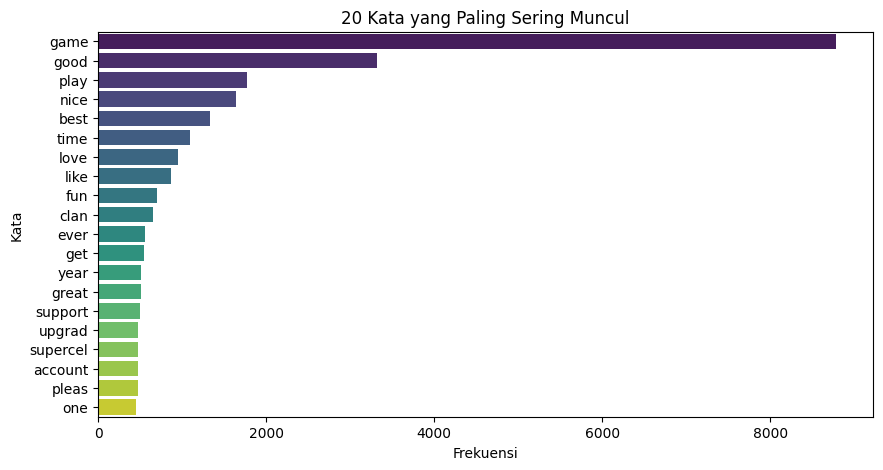

In [47]:
# Menampilkan 30 kata yang paling sering muncul
all_tokens = [word for text in review_data['content_clean'] for word in text.split()]
word_freq = Counter(all_tokens)
most_common_words = word_freq.most_common(20)
print(most_common_words)

# Visualisasi frekuensi kata
words, counts = zip(*most_common_words)
plt.figure(figsize=(10, 5))
sns.barplot(x=list(counts), y=list(words), palette='viridis')
plt.title('20 Kata yang Paling Sering Muncul')
plt.xlabel('Frekuensi')
plt.ylabel('Kata')
plt.show()

In [48]:
# Convert dataframe ke csv
review_data.to_csv('review_data_clean.csv', index=False)